In [1]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Earth Engine
ee.Initialize()

In [7]:
LC8_BANDS = ['ST_B10','QA_PIXEL']; #Landsat 8
LC5_BANDS = ['ST_B6', 'QA_PIXEL']
STD_NAMES = ['Temp', 'QA']

	

import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Earth Engine
ee.Initialize()

all_lakes = ee.FeatureCollection('projects/ee-mazarderakhsh/assets/ALAP-ALTM-195-centroids') \
    .filter(ee.Filter.gte('Field1', 1)) \
    .filter(ee.Filter.lte('Field1', 199))  # pick only ALTM lakes

# Convert the lakes FeatureCollection to a List
lakesList = all_lakes.toList(all_lakes.size())


# Define a function to mask clouds and cloud shadows from Landsat 5 surface reflectance imagery
def maskL457sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    waterMask = image.select('QA_PIXEL').eq(5440).Or(image.select('QA_PIXEL').eq(5504))
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    return image.addBands(opticalBands, None, True).addBands(thermalBand, None, True).updateMask(qaMask).updateMask(
        saturationMask).updateMask(waterMask)


def maskL8sr(image):
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(-124.15)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True) \
        .updateMask(qaMask) \
        .updateMask(saturationMask)


def reflectance(img, lake):
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake, scale=30).select(STD_NAMES)
    return img.set('DATE_SMP', img.date().format()).set('reflectance', reflectance_values)

# Initialize an empty list to store the filtered DataFrames for each lake
filtered_dfs = []

# Loop over each lake in the list
for i in range(lakesList.size().getInfo()):
    lake = ee.Feature(lakesList.get(i))
    lat = ee.Number(lake.geometry().coordinates().get(1))
    lon = ee.Number(lake.geometry().coordinates().get(0))
    lake_point = ee.Geometry.Point([lon, lat]).buffer(100)
    lakeName = ee.String(lake.get('NAME')).getInfo()
    lakeID = ee.String(lake.get('Field1')).getInfo()

    # Retrieve Landsat 5 imagery for the specific lake
    l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
        .filter(ee.Filter.calendarRange(5, 12, 'month')) \
        .filterBounds(lake_point) \
        .filter(ee.Filter.lt('CLOUD_COVER', 15)) \
        .map(maskL457sr) \
        .select(LC5_BANDS, STD_NAMES)

    l8 =ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filter(ee.Filter.calendarRange(5, 12, 'month')) \
            .filterBounds(lake_point) \
            .filter(ee.Filter.lt('CLOUD_COVER', 15)) \
            .map(maskL8sr) \
            .select(LC8_BANDS, STD_NAMES)

    lall = ee.ImageCollection(l5.merge(l8));


    # Map the reflectance function over the Landsat 5 ImageCollection for the specific lake
    map_reflectance = lall.map(lambda img: reflectance(img, lake_point))

    # Reduce the mapped image collection to get reflectance values for the specific lake
    list_reflectance = map_reflectance.reduceColumns(ee.Reducer.toList(2), ['DATE_SMP', 'reflectance']).values().get(0)

    # Convert the results to a pandas DataFrame
    df_reflectance = pd.DataFrame(list_reflectance.getInfo(), columns=['DATE_SMP', 'reflectance'])
    df_reflectance['DATE_SMP'] = pd.to_datetime(df_reflectance['DATE_SMP'])
    df_reflectance['DATE_SMP'] = df_reflectance['DATE_SMP'].dt.date
    df_reflectance['reflectance'] = df_reflectance['reflectance'].apply(
        lambda x: {k: v for k, v in x.items() if v is not None})

    # Unpack the 'reflectance' dictionary and create separate columns for each band
    df_reflectance = pd.concat([df_reflectance.drop('reflectance', axis=1),
                                df_reflectance['reflectance'].apply(pd.Series).astype('float64', errors='ignore')],
                               axis=1)

    # Add a new column for the lake name
    df_reflectance['PONDNO'] = lakeID
    df_reflectance['PONDNAME'] = lakeName

    # Add the DataFrame to the list
    filtered_dfs.append(df_reflectance)

# Concatenate all filtered DataFrames into a single DataFrame
df_filtered_lakes = pd.concat(filtered_dfs, ignore_index=True)

# Sort the DataFrame by 'DATE' in ascending order
df_filtered_lakes.sort_values(by='DATE_SMP', inplace=True)

# remove data based on Temp < 10
df_filtered_lakes

,DATE_SMP,QA,Temp,PONDNO,PONDNAME
33356,1984-05-07,5504.000000,11.556291,138,Union Falls Pond
2789,1984-05-07,5440.000000,13.655420,169,Grass Pond
41431,1984-05-07,5440.000000,5.618934,61,Lake Colby
7218,1984-05-07,5440.000000,4.939117,94,Mirror Lake
10665,1984-05-07,5497.175855,11.541103,187,Queer Lake
...,...,...,...,...,...
13847,2023-12-22,21952.000000,-2.597490,54,Kiwassa Lake
30565,2023-12-22,23720.134484,-4.562440,114,Rat Pond
6192,2023-12-22,22124.195111,-4.275370,64,Lake Everest
30994,2023-12-22,NaN,NaN,172,Lake Colden


In [8]:
df_filtered_lakes.dropna(inplace=True)
df_filtered_lakes

,DATE_SMP,QA,Temp,PONDNO,PONDNAME
33356,1984-05-07,5504.000000,11.556291,138,Union Falls Pond
2789,1984-05-07,5440.000000,13.655420,169,Grass Pond
41431,1984-05-07,5440.000000,5.618934,61,Lake Colby
7218,1984-05-07,5440.000000,4.939117,94,Mirror Lake
10665,1984-05-07,5497.175855,11.541103,187,Queer Lake
...,...,...,...,...,...
43114,2023-12-22,21952.000000,-2.527883,60,Lake Clear
13847,2023-12-22,21952.000000,-2.597490,54,Kiwassa Lake
30565,2023-12-22,23720.134484,-4.562440,114,Rat Pond
6192,2023-12-22,22124.195111,-4.275370,64,Lake Everest


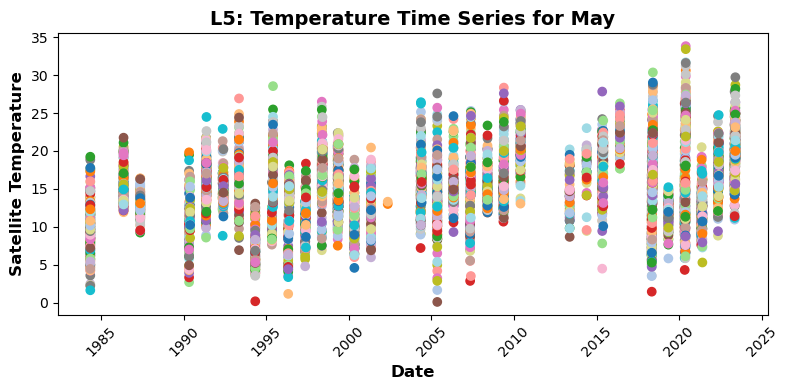

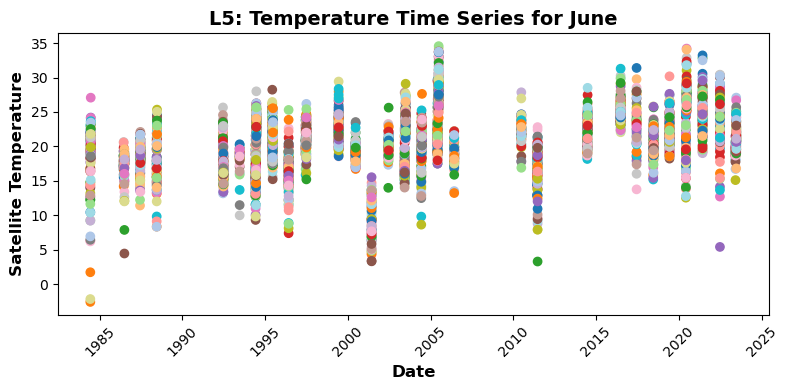

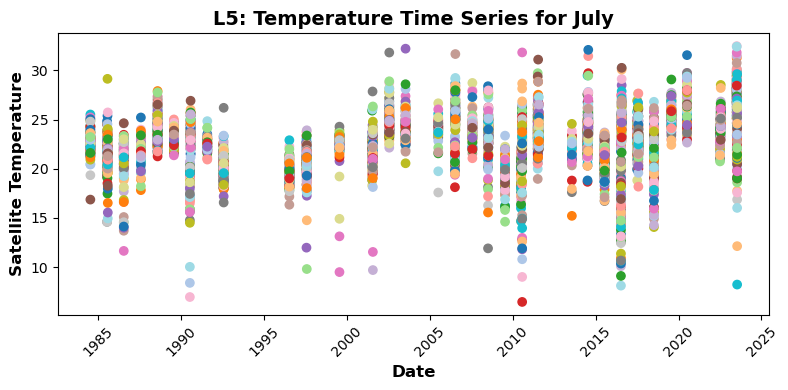

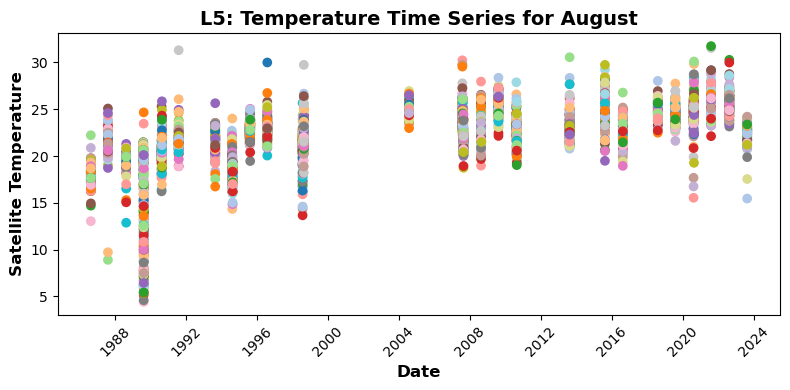

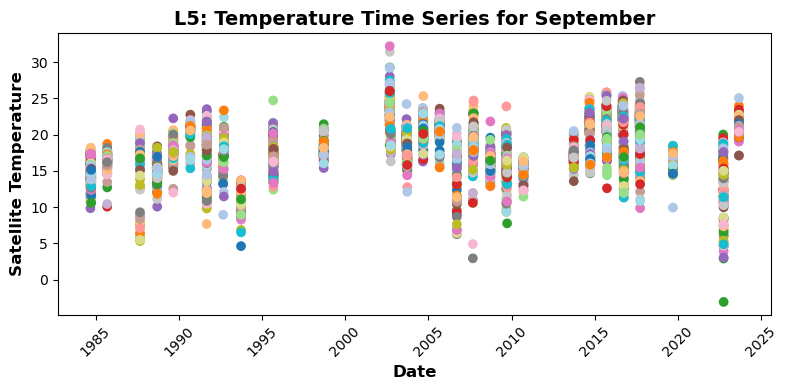

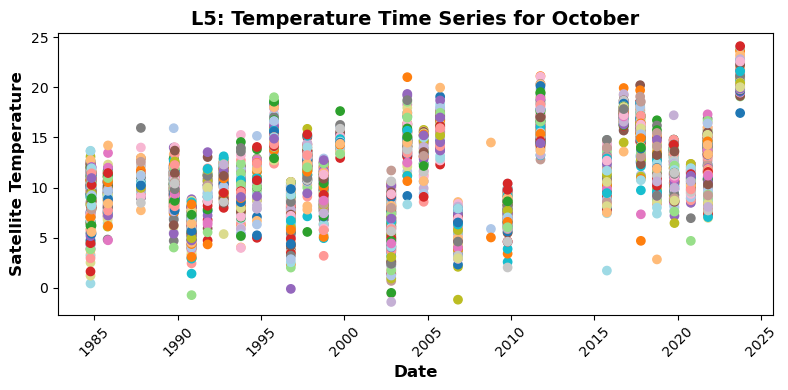

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Convert 'DATE_SMP' column to datetime type if it's not already
df_filtered_lakes['DATE_SMP'] = pd.to_datetime(df_filtered_lakes['DATE_SMP'])

# Define the months for which you want to plot the time series
months = ['May', 'June', 'July', 'August', 'September', 'October']

# Define a colormap to generate a sequence of colors
cmap = plt.get_cmap('tab20')  # You can choose any colormap you prefer

# Iterate over months and create separate plots
for month in months:
    # Filter DataFrame for the current month
    df_month = df_filtered_lakes[df_filtered_lakes['DATE_SMP'].dt.month_name() == month]
    
    # Create a new figure and axis object for each month
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Generate a sequence of colors from the colormap for each data point
    num_points = len(df_month)
    colors = [cmap(i % cmap.N) for i in range(num_points)]
    
    # Plot time series for current month with different colors for each data point
    ax.scatter(df_month['DATE_SMP'], df_month['Temp'], color=colors)
    
    # Set x-axis label with increased font size and bold text
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    
    # Set y-axis label with increased font size and bold text
    ax.set_ylabel('Satellite Temperature', fontsize=12, fontweight='bold')
    
    # Set title with increased font size and bold text
    ax.set_title(f'L5: Temperature Time Series for {month}', fontsize=14, fontweight='bold')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    # plt.ylim(12,35)
    # Show plot
    plt.tight_layout()
    plt.show()


C:\Users\Faculty\AppData\Local\Temp\ipykernel_5048\2718059442.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered_lakes, x='Month', y='Temp', palette='viridis', showfliers=False, order=month_order)


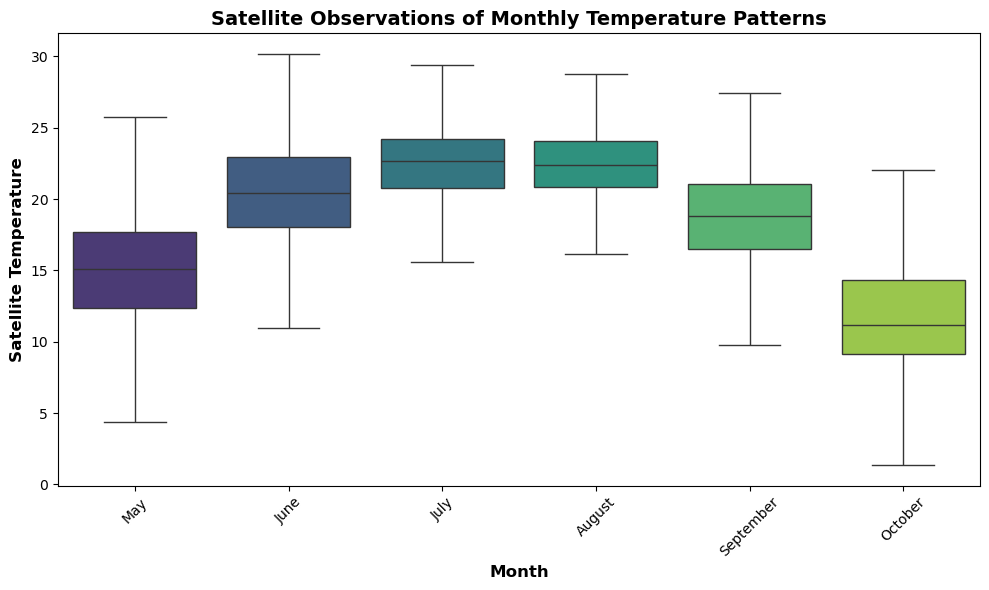

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'DATE_SMP' column to datetime type if it's not already
df_filtered_lakes['DATE_SMP'] = pd.to_datetime(df_filtered_lakes['DATE_SMP'])

# Extract month name from the 'DATE_SMP' column
df_filtered_lakes['Month'] = df_filtered_lakes['DATE_SMP'].dt.month_name()

# Define the order of months
month_order = ['May', 'June', 'July', 'August', 'September', 'October']

# Create the box plot using Seaborn with sorted months
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered_lakes, x='Month', y='Temp', palette='viridis', showfliers=False, order=month_order)

# Set x-axis label with increased font size and bold text
plt.xlabel('Month', fontsize=12, fontweight='bold')

# Set y-axis label with increased font size and bold text
plt.ylabel('Satellite Temperature', fontsize=12, fontweight='bold')

# Set title with increased font size and bold text
plt.title('Satellite Observations of Monthly Temperature Patterns', fontsize=14, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()
